In [1]:
import requests
import json
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
#pip install pymer4
#!pip install rpy2
from pymer4.models import Lmer

In [2]:
# Install package for frequentist models
import rpy2.robjects as robjects

# R's install.packages function is used to install lme4
#robjects.r('install.packages("lme4", repos="http://cran.r-project.org")')

In [3]:
# Set directory to Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/STA365')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Read data
df = pd.read_csv('zone_entries.csv')
# Remove the 4th period - not to our interest
df = df[df["Period"] != 4]

# EDA

In [5]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
# Show first 5 columns
df.head(5)

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,isin_ozone_for_home_team,isin_ozone_for_away_team,zone_entry_success,Position,is_forward,Entry_Type,Game,Dumped,Played
0,2023-11-08,Women - United States,Women - Canada,1,19:36,5,5,0,0,Women - Canada,Blayre Turnbull,Zone Entry,125,6,Carried,NaN,NaN,NaN,Haley Winn,NaN,NaN,False,True,False,F,True,Carried,2023-11-08,0,0
1,2023-11-08,Women - United States,Women - Canada,1,19:23,5,5,0,0,Women - United States,Hilary Knight,Zone Entry,125,52,Dumped,NaN,NaN,NaN,Erin Ambrose,NaN,NaN,True,False,False,F,True,Dumped,2023-11-08,1,0
2,2023-11-08,Women - United States,Women - Canada,1,19:18,5,5,0,0,Women - Canada,Sarah Fillier,Zone Entry,125,80,Carried,NaN,NaN,NaN,Rory Guilday,NaN,NaN,False,True,False,F,True,Carried,2023-11-08,0,0
3,2023-11-08,Women - United States,Women - Canada,1,18:56,5,5,0,0,Women - United States,Hannah Bilka,Zone Entry,126,84,Played,NaN,NaN,NaN,Ashton Bell,NaN,NaN,True,False,False,F,True,Played,2023-11-08,0,1
4,2023-11-08,Women - United States,Women - Canada,1,18:48,5,5,0,0,Women - Canada,Brianne Jenner,Zone Entry,125,63,Carried,NaN,NaN,NaN,Savannah Harmon,NaN,NaN,False,True,False,F,True,Carried,2023-11-08,0,0


## Resonpse Variable - Successful Zone Entry

This is our response of interest - what factors associated with a zone entry can be related to a goal?

In [6]:
# Get numerical summary of zone entry success
group_counts = df.groupby('zone_entry_success').size()
print(group_counts)

zone_entry_success
False    328
True     199
dtype: int64


Takeaway: 130 more zone entries did not result in a goal.

In [7]:
group_counts = df.groupby(['zone_entry_success', 'Entry_Type']).size()
print(group_counts)

zone_entry_success  Entry_Type
False               Carried       122
                    Dumped        165
                    Played         41
True                Carried       136
                    Dumped         41
                    Played         22
dtype: int64


In [8]:
group_counts = df.groupby(['Entry_Type', 'zone_entry_success']).size()
print(group_counts)

Entry_Type  zone_entry_success
Carried     False                 122
            True                  136
Dumped      False                 165
            True                   41
Played      False                  41
            True                   22
dtype: int64


Takeaway: Zone entries with type "carried" resulted in more goals among successful zone entries, while dumpings often do not result in goals. Zone entries with type "played" is infrequent compared to other types.

## Covariate Variable - Y Coordinate

Motivation: Where zone entry happens could be associated with if the zone entry is successful, since teams have different strategy when placing their defencers, and the distance to the goal can vary based on the Y-coordinate.

In [9]:
## Find center of y-coordinate of a hockey ground
center = 0.5*sum([df['Y Coordinate'].min(), df['Y Coordinate'].max()])
center
## Convert current y-coordinate (centering)
df['Y_coordinate_centered'] = df['Y Coordinate'] - center
## Check that conversion works
df['Y Coordinate'].head(5), df['Y_coordinate_centered'].head(5)

(0     6
 1    52
 2    80
 3    84
 4    63
 Name: Y Coordinate, dtype: int64,
 0   -36.5
 1     9.5
 2    37.5
 3    41.5
 4    20.5
 Name: Y_coordinate_centered, dtype: float64)

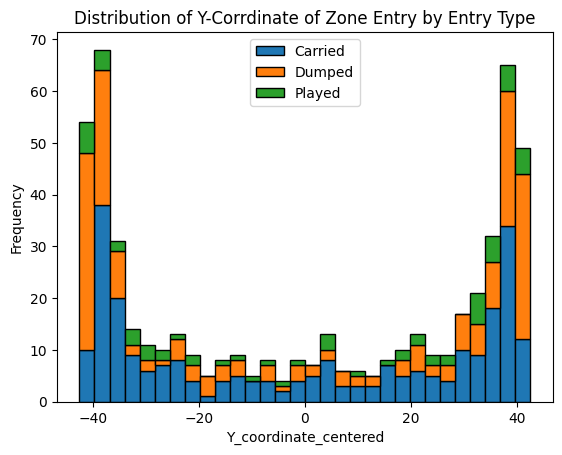

In [10]:
## Plot the distribution of Y coordinates
# Create a histogram
plt.hist([df.loc[df['Entry_Type'] == category, 'Y_coordinate_centered']
          for category in df['Entry_Type'].unique()],
         bins=30,
         stacked=True,
         label=df['Entry_Type'].unique(),
         edgecolor='black')

# Add titles and labels
plt.title('Distribution of Y-Corrdinate of Zone Entry by Entry Type')
plt.xlabel('Y_coordinate_centered')
plt.ylabel('Frequency')
plt.legend()
# Show the plot
plt.show()

Takeaway: Zone entries overall took place more frequently at sides, and dumping was more likely to happen at sides.

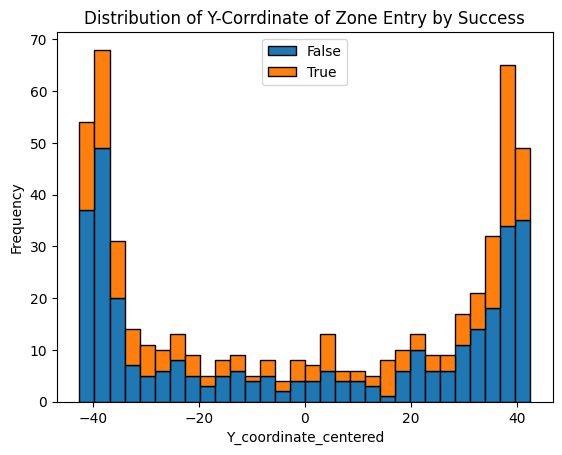

In [11]:
## Plot the distribution of Y coordinates
# Create a histogram
plt.hist([df.loc[df['zone_entry_success'] == category, 'Y_coordinate_centered']
          for category in df['zone_entry_success'].unique()],
         bins=30,
         stacked=True,
         label=df['zone_entry_success'].unique(),
         edgecolor='black')

# Add titles and labels
plt.title('Distribution of Y-Corrdinate of Zone Entry by Success')
plt.xlabel('Y_coordinate_centered')
plt.ylabel('Frequency')
plt.legend()
# Show the plot
plt.show()

Takeaway: While zone entries took place more frequently at sides, it is difficult to say whether the success rate of zone entry is associated with Y-coordinate.

## Covariate Variable - Period

Motivation: Period of the game could play a role in the effectiveness of a zone entry through players' emotion, physical abilities and teams' strategies.

In [12]:
group_counts = df.groupby(['Period']).size()
print(group_counts)

Period
1    174
2    160
3    193
dtype: int64


Takeaway: More zone entries took place in the last period - maybe players are more anxious to play offensive.

In [13]:
group_counts = df.groupby(['zone_entry_success', 'Period']).size()
print(group_counts)

zone_entry_success  Period
False               1         105
                    2          99
                    3         124
True                1          69
                    2          61
                    3          69
dtype: int64


In [14]:
group_counts = df.groupby(['Period', 'zone_entry_success']).size()
print(group_counts)

Period  zone_entry_success
1       False                 105
        True                   69
2       False                  99
        True                   61
3       False                 124
        True                   69
dtype: int64


Takeaway: More zone entries made in period 3, but the overall success numbers of entries across all periods are very close. Therefore, we can say that players may play more offensive in period 3, but the denfensive team also reacts to those offenses actively, bringing the success rate of zone entry in period 3 down.

In [15]:
group_counts = df.groupby(['Period', 'Entry_Type']).size()
print(group_counts)

Period  Entry_Type
1       Carried       88
        Dumped        70
        Played        16
2       Carried       76
        Dumped        63
        Played        21
3       Carried       94
        Dumped        73
        Played        26
dtype: int64


In [16]:
group_counts = df.groupby(['Entry_Type', 'Period']).size()
print(group_counts)

Entry_Type  Period
Carried     1         88
            2         76
            3         94
Dumped      1         70
            2         63
            3         73
Played      1         16
            2         21
            3         26
dtype: int64


Takeaway: Zone entry type of carried is more frequent across all entry types; besides that, not much of variation of zone entries types across periods.

## Frequentist GLMM (Having some issues with code)

In [16]:
df.head(1)

,Date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,isin_ozone_for_home_team,isin_ozone_for_away_team,zone_entry_success,Position,is_forward,Entry_Type,Game,Dumped,Played,Y_coordinate_centered
0,2023-11-08,Women - United States,Women - Canada,1,19:36,5,5,0,0,Women - Canada,Blayre Turnbull,Zone Entry,125,6,Carried,NaN,NaN,NaN,Haley Winn,NaN,NaN,False,True,False,F,True,Carried,2023-11-08,0,0,-36.5


In [84]:
df["Game"].unique()

array(['2023-11-08', '2023-11-11', '2023-12-14', '2023-12-16'],
      dtype=object)

In [37]:
df2 = df[["Period", "Clock", "Team", "Player", "Game", "Y_coordinate_centered", "Entry_Type", "zone_entry_success"]]

In [17]:
glmm1 = Lmer('zone_entry_success ~ Period + Team + Entry_Type + Y_coordinate_centered + (1|Player)', data=df, family='binomial')
result_glmm1 = glmm1.fit()

# Displaying the results
print(result_glmm1.summary())

AttributeError: module 'rpy2.robjects.conversion' has no attribute 'get_conversion'

In [19]:
from rpy2.robjects import conversion, default_converter
with conversion.localconverter(default_converter):
  glmm1 = Lmer('zone_entry_success ~ Period + Team + Entry_Type + Y_coordinate_centered + (1|Player)', data=df, family='binomial')
  result_glmm1 = glmm1.fit()

# Displaying the results
print(result_glmm1.summary())

AttributeError: module 'rpy2.robjects.conversion' has no attribute 'get_conversion'

In [42]:
#pip install rpy2==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314932 sha256=5fd1bd4f59b652fb8d1d26df143fad44008f15b252b6ab294fa7e9794b8a75e3
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.15
    Uninstalling rpy2-3.5.15:
      Successfully uninstalled rpy2-3.5.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymer4 0.8.1 requires rpy2>=3.5.3, but you have rpy2 3.5.1 which is incompatible.
